## Can we find a model that predicts breakthrough curve metrics based on the input parameters?
Start with late time tailing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
plt.style.use('ggplot')

/Users/williamtaylor/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/williamtaylor/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/williamtaylor/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/williamtaylor/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

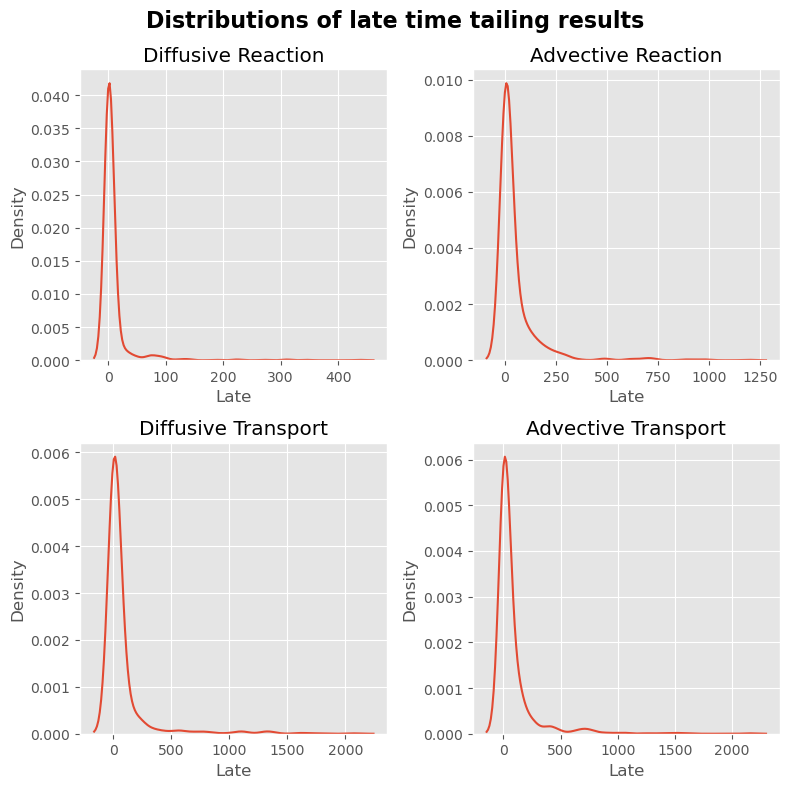

In [3]:
# visualize the results metrics
keys = ['dr','ar','dt','at']
colors = ['blue','purple','orange','red']
titles = ['Diffusive Reaction','Advective Reaction','Diffusive Transport','Advective Transport']

fig, axes = plt.subplots(2,2,figsize=(8,8))

axes = axes.flatten()

for i,ax in enumerate(axes):
    # load metrics dataframe
    data = pd.read_csv(f'results/metrics_{keys[i]}.csv', index_col=0)
    sns.kdeplot(data['Late'], ax=ax)
    ax.set_title(titles[i])
fig.suptitle('Distributions of late time tailing results', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# Initialize lists to store data
params_list = []
metrics_list = []

# Loop through keys to process JSON and CSV files
for key in keys:
    # Read JSON file
    with open(f'results/btc_data_{key}.json', 'r') as f:
        btc_data = json.load(f)
    for entry in btc_data:
        params_list.append(entry['params'])
    
    # Read metrics CSV
    data = pd.read_csv(f'results/metrics_{key}.csv', index_col=0)
    metrics_list.append(data)

# Create DataFrame for parameters
params_df = pd.DataFrame(params_list, columns=['theta', 'rho_b', 'dispersivity', 'lamb', 'alpha', 'kd'])

# Combine all metrics into a single DataFrame
metrics_df = pd.concat(metrics_list, ignore_index=True)

# Combine parameters and metrics
predictors = pd.concat([params_df, metrics_df], axis=1)

# Check resulting DataFrame
predictors.head()

,theta,rho_b,dispersivity,lamb,alpha,kd,Early,Peak,Late
0,0.260547,0.867734,56.079955,45.287224,3.92419,0.604296,0.03,0.25,0.41
1,0.548828,0.867734,56.079955,45.287224,3.92419,0.604296,0.03,0.23,0.39
2,0.260547,0.595859,56.079955,45.287224,3.92419,0.604296,0.03,0.23,0.35
3,0.260547,0.867734,43.610754,45.287224,3.92419,0.604296,0.03,0.23,0.43
4,0.260547,0.867734,56.079955,1.408710,3.92419,0.604296,0.03,0.25,3.39


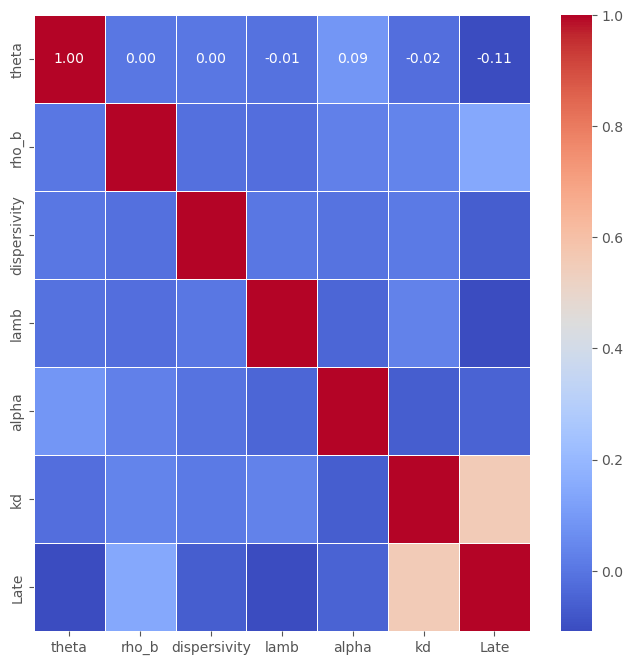

In [5]:
late = predictors.columns.drop(['Early','Peak'])
correlation_matrix = predictors[late].corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

In [6]:
# no easily discernable correlations
# start modeling
import sklearn.model_selection as skm
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
import xgboost as xgb

In [7]:
y = predictors['Late']
terms = predictors.columns.drop(['Early','Peak','Late'])
X = predictors[terms]

X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# gradient boosting regressor
boost_late = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_late.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

Text(0, 0.5, 'Training error')

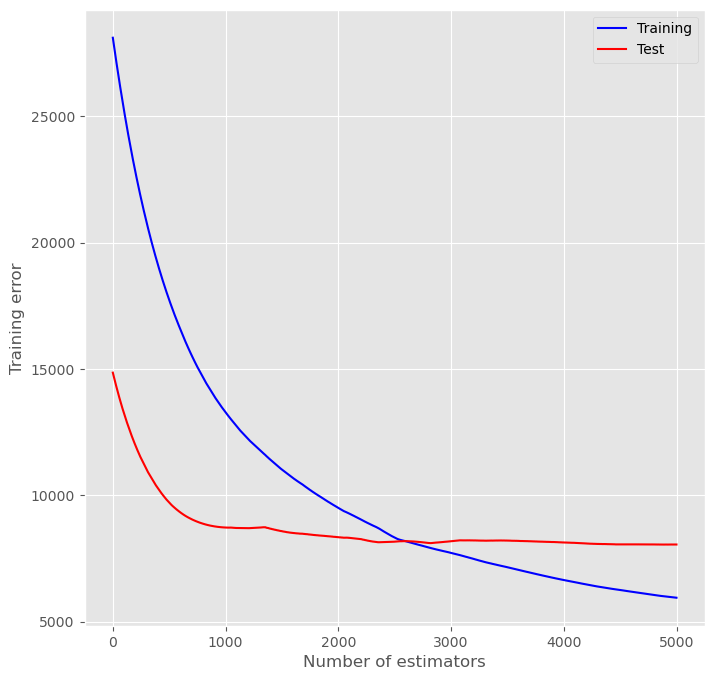

In [9]:
test_error = np.zeros_like(boost_late.train_score_)
for idx,y_ in enumerate(boost_late.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_late.train_score_.shape[0])
ax = plt.subplots(figsize=(8,8))[1]
ax.plot(plot_idx ,
boost_late.train_score_ ,'b',label='Training')
ax.plot(plot_idx ,test_error ,'r',label='Test')
ax.legend()
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Training error')

In [10]:
# regression model
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS, summarize, poly)

In [11]:
X_train = sm.add_constant(X_train)
regression_model = sm.OLS(y_train, X_train)
regression_results = regression_model.fit()
regression_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Late   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     270.2
Date:                Fri, 17 Jan 2025   Prob (F-statistic):          1.83e-274
Time:                        14:20:50   Log-Likelihood:                -18110.
No. Observations:                2867   AIC:                         3.623e+04
Df Residuals:                    2860   BIC:                         3.628e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           35.5844     11.477      3.100      0.002      13.080      58.089
theta         -137.2871     19.396     -7.078      0.000    -175.318     -99.256
rho_b           52.9172      6.011      8.803      0.000      41.130      64.704
dispersivity    -0.4779      0.107     -4.458      0.000      -0.688      -0.268
lamb            -1.0247      0.124     -8.246      0.000      -1.268      -0.781
alpha           -0.1411      0.125     -1.128      0.260      -0.386       0.104
kd               4.4627      0.120     37.185      0.000       4.227       4.698
==============================================================================
Omnibus:                     2712.447   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           197907.162
Skew:                           4.315   Prob(JB):                         0.00
Kurtosis:                      42.777   Cond. No.                         278.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""